In [1]:
%load_ext load_style
%load_style talk.css

# Interpolate 2D field on regular and irregular grids

From https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html, we know There are several general interpolation facilities available in SciPy, for data in 1, 2, and higher dimensions:

* A class representing an interpolant (interp1d) in 1-D, offering several interpolation methods.
* Convenience function griddata offering a simple interface to interpolation in N dimensions (N = 1, 2, 3, 4, ...). Object-oriented interface for the underlying routines is also available.
* Functions for 1- and 2-dimensional (smoothed) cubic-spline interpolation, based on the FORTRAN library FITPACK. There are both procedural and object-oriented interfaces for the FITPACK library.
* Interpolation using Radial Basis Functions.

In this notebook, we mainly use **interp2d** for regular grids while **griddata** for irregular grids.

## 1. Load basic libs

In [2]:
% matplotlib inline

import numpy as np
from scipy.interpolate import interp2d, griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed

from netCDF4 import Dataset as netcdf # netcdf4-python module

## 2. Work on regular grids

### 2.1 Extract data from skt data

In [3]:
ncset= netcdf(r'data\skt.mon.mean.nc')

lon = ncset['lon'][:]  
lat = ncset['lat'][:]            
skt = ncset['skt'][0,:,:]   
skt.shape

(94L, 192L)

### 2.2 Prepare new grids of longitude and latitude

Keep longitude and latitude in a monotonic increasing manner

In [4]:
lat_new = np.linspace(np.min(lat), np.max(lat), skt.shape[0]*2)
lon_new = np.linspace(np.min(lon), np.max(lon), skt.shape[1]*2)

### 2.3 Contruct interploate function and apply to new grids

In [5]:
func = interp2d(lon, lat, skt, kind='cubic')
# apply to new level and latitude
sktnew = func(lon_new, lat_new)

### 2.4 Have a comparision plot

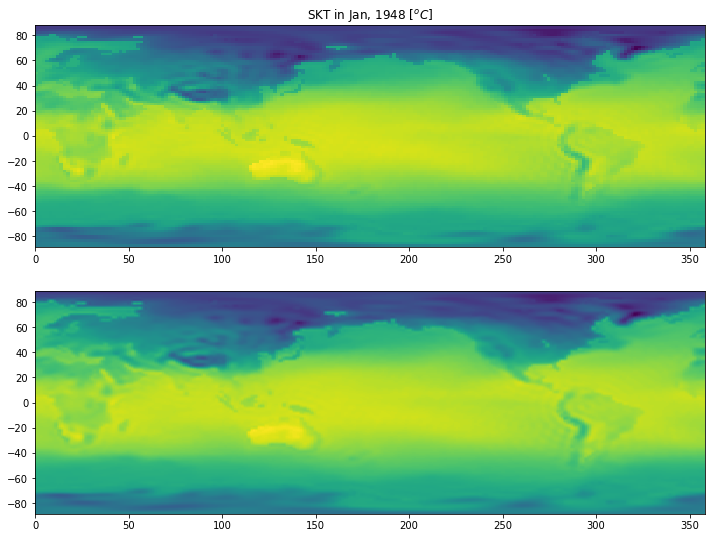

In [6]:
f, axarr = plt.subplots(2)
f.set_figwidth(12)
f.set_figheight(9)

[lons, lats] = np.meshgrid(lon, lat)
axarr[0].pcolormesh(lons, lats, skt)
axarr[0].set_title('SKT in Jan, 1948 [$^oC$]')

[lons_new, lats_new] = np.meshgrid(lon_new, lat_new)
axarr[1].pcolormesh(lons_new, lats_new, sktnew)

## 3. Work on irregular grids

A commonly asked question on the matplotlib mailing lists is "how do I make a contour plot of my irregularly spaced data?". The answer is, first you interpolate it to a regular grid. As of version 0.98.3, matplotlib provides a griddata function that behaves similarly to the matlab version. It performs "natural neighbor interpolation" of irregularly spaced data a regular grid, which you can then plot with contour, imshow or pcolor.

### 3.1 Have a try on fake data

An example from http://scipy-cookbook.readthedocs.io/items/Matplotlib_Gridding_irregularly_spaced_data.html

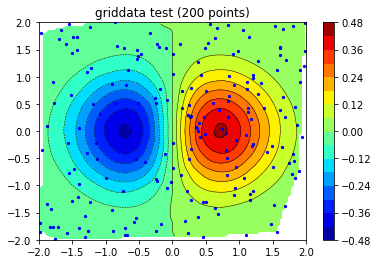

In [7]:
# make up some randomly distributed data
seed(1234)
npts = 200
x = uniform(-2,2,npts)
y = uniform(-2,2,npts)
z = x*np.exp(-x**2-y**2)
# define grid.
xi = np.linspace(-2.1,2.1,100)
yi = np.linspace(-2.1,2.1,100)
# grid the data.
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
# plot data points.
plt.scatter(x,y,marker='o',c='b',s=5)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('griddata test (%d points)' % npts)

### 3.2 Try skt data


Here the interpolation method of griddata is used. Before using it, have to use ravel to transform data from 2D into 1D array (i.e., like scatter dots).

In [8]:
# grid the data.
skt_new = griddata((lons.ravel(), lats.ravel()), skt.ravel(), (lon_new[None,:], lat_new[:,None]), method='cubic')

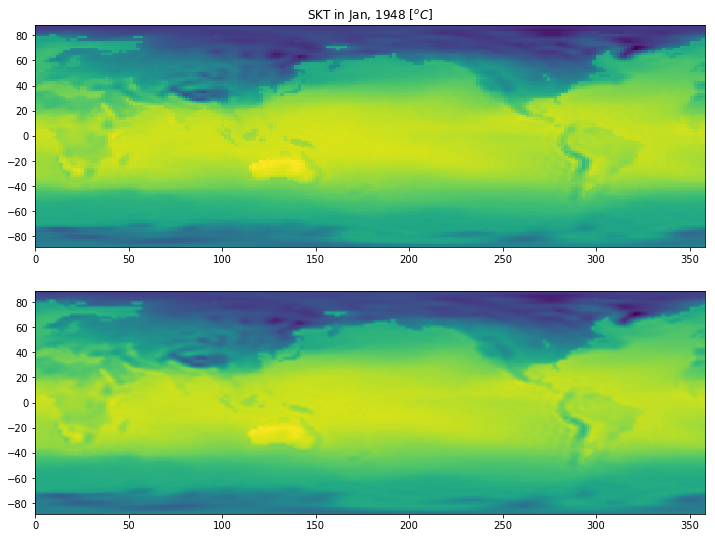

In [9]:
f, axarr = plt.subplots(2)
f.set_figwidth(12)
f.set_figheight(9)

[lons, lats] = np.meshgrid(lon, lat)
axarr[0].pcolormesh(lons, lats, skt)
axarr[0].set_title('SKT in Jan, 1948 [$^oC$]')

[lons_new, lats_new] = np.meshgrid(lon_new, lat_new)
axarr[1].pcolormesh(lons_new, lats_new, skt_new)

## References

http://unidata.github.io/netcdf4-python/

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Kalnay et al.,The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., 77, 437-470, 1996.